<a href="https://colab.research.google.com/github/yoavdana/ex1_DL/blob/main/ex1_DL_copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yoavdana/ex1_DL.git

Cloning into 'ex1_DL'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 103 (delta 36), reused 48 (delta 9), pack-reused 0
Receiving objects: 100% (103/103), 59.22 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [129]:
import torch 
import numpy as np
import scipy.stats as si
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.utils.data as data
import time
import matplotlib.pyplot as plt
INPUT_DIM = 9 * 20
OUTPUT_DIM = 2



In [121]:
SEQ_LENGTH=20


class DataProccesing(data.Dataset):


    def data_to_input(self,sequence, pos_or_neg):
        mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
                  'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
        map=np.zeros((9, 20))
        for i, seq in enumerate(sequence):
            map[i,mapping[seq]]+=1
        map = map.flatten()
        return np.concatenate([map, np.array([pos_or_neg])])


    def Read_Data(self,filename, pos_or_neg):
        file = open(filename, 'r')
        lines=file.readlines()
        DATA = np.zeros((len(lines), 181))
        for i, line in enumerate(lines):
            input = self.data_to_input(line.replace('\n', ''), pos_or_neg)
            DATA[i] = input
        return DATA


    # def bootstrap(self,DATA,size,NUMBER_OF_BATCHS):

    #     new_DATA=np.zeros((size,181))
    #     N=DATA.shape[0]
    #     batch_size=N//NUMBER_OF_BATCHS
    #     for i in range(NUMBER_OF_BATCHS):

    #         random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
    #         new_DATA[((size//NUMBER_OF_BATCHS)*i):(size//NUMBER_OF_BATCHS)*(i+1), :] = DATA[random, :]
    #     return new_DATA

    def bootstrap(self,DATA,size,NUMBER_OF_BATCHS):

        N=DATA.shape[0]
        batch_size=N//NUMBER_OF_BATCHS
        for i in range(NUMBER_OF_BATCHS):

            random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
            DATA =np.vstack([DATA,DATA[random, :]])
        return DATA


    def DATA_pre_pros(self,filename_pos,filename_neg):

        neg_data=self.Read_Data(filename_neg, 0)
        pos_data=self.Read_Data(filename_pos, 1)
        
        neg_data_train = neg_data[:int(len(neg_data)*0.9)]
        neg_data_test = neg_data[int(len(neg_data)*0.9):]
        pos_data_train = pos_data[:int(len(pos_data)*0.9)]
        pos_data_test = pos_data[int(len(pos_data)*0.9):]
        #pos_data_train = self.bootstrap(pos_data_train, int(BOOTSTRAP_SIZE*0.9), int(NUMBER_OF_BATCHS*0.9))
        #pos_data_test = self.bootstrap(pos_data_test, int(BOOTSTRAP_SIZE*0.1), int(NUMBER_OF_BATCHS*0.1))

        final_data_train = np.concatenate([neg_data_train, pos_data_train])
        np.random.shuffle(final_data_train)

        final_data_test = np.concatenate([neg_data_test, pos_data_test])
        np.random.shuffle(final_data_test)

        return final_data_train, final_data_test



    def shuffle_data(self,data_Xy):
        np.random.shuffle(data_Xy)
        return data_Xy[:,:180],data_Xy[:,-1]


    def spike_seq(self,filename):

        mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
                  'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


        with open(filename) as f:
            lines = f.readlines()[0]
            print(lines)
            predeict=list()

            if len(lines) == 9:
                map = np.zeros((9, 20))
                for i, seq in enumerate(lines):
                    map[i, mapping[seq]] += 1
                map = map.flatten()
                predeict.append(map)
            else:
                for i in range(len(lines)-9):
                    map = np.zeros((9, 20))
                    for i, seq in enumerate(lines[i:i+9]):
                        map[i, mapping[seq]] += 1
                    map = map.flatten()
                    predeict.append(map)
            
            return np.array(predeict)




In [148]:
INPUT_1=10
INPUT_2=10
INPUT_3=5
P_DROPOUT=0.4
P_DROPOUT2=0.15

class NetWork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, INPUT_1)
        
        self.hidden_1_fc = nn.Linear(INPUT_1, INPUT_2)
        
        self.hidden_2_fc = nn.Linear(INPUT_2, INPUT_3)
        
        self.output_fc = nn.Linear(INPUT_3, output_dim)

        self.dropout = nn.Dropout(P_DROPOUT)
        self.dropout2 = nn.Dropout(P_DROPOUT2) 
        self.batch_norm_1 = nn.BatchNorm1d(INPUT_1)

        self.batch_norm_2 = nn.BatchNorm1d(INPUT_2)

        self.batch_norm_3 = nn.BatchNorm1d(INPUT_3)

        

    def forward(self, x):
   

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        h_1 = F.relu(self.input_fc(x))
       
        h_1=self.batch_norm_1(h_1)

        h_1=self.dropout(h_1)

        h_2 = F.relu(self.hidden_1_fc(h_1))

        #h_2=self.batch_norm_2(h_2)

        #h_2=self.dropout(h_2)

        h_3 = F.relu(self.hidden_2_fc(h_2))

        h_3=self.batch_norm_3(h_3)

        #h_3=self.dropout2(h_3)

        y_pred = self.output_fc(h_3)

       
        
        return y_pred, h_2


In [140]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim = True)
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
#     return acc


# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim = True)
    
#     f1 = f1_score(y_pred,y)

#     return f1

def f1_loss(y_true, y_pred, is_training=False):

  
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
   
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
       
   
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
   
    epsilon = 1e-7
   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
   
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1



def train(model, iterator_x, iterator_y, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, x in enumerate(iterator_x):
        x = x.to(device)
        y = iterator_y[i].to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)

        #acc = calculate_accuracy(y_pred, y)
        acc=f1_loss(y, y_pred, is_training=False)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator_x), epoch_acc / len(iterator_x)


def evaluate(model, iterator_x, iterator_y, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for i, x in enumerate(iterator_x):
        x = x.to(device)
        y = iterator_y[i].to(device)

        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)

        #acc = calculate_accuracy(y_pred, y)
        acc=f1_loss(y, y_pred, is_training=False)
 
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator_x), epoch_acc / len(iterator_x)




    

In [85]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

my_ds = DataProccesing()
train_set, test_set=my_ds.DATA_pre_pros(filename_pos,filename_neg)
train_dataloader=data.DataLoader(dataset=train_set, batch_size=64,shuffle=True)
test_dataloader= data.DataLoader(dataset=test_set, batch_size=64,shuffle=True )
print(np.sum(train_set[:, -1]))

# LEARNNING_RATE=0.00015

def main():
    model = NetWork(INPUT_DIM, 2)
    print(f'The model has {count_parameters(model):,} trainable parameters')
    optimizer = optim.Adam(model.parameters(),lr=LEARNNING_RATE)

    # weights = [np.sum(train_set[:, -1])/train_set.shape[0], 1-np.sum(train_set[:, -1])/train_set.shape[0]] #as class distribution
    # class_weights = torch.FloatTensor(weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)




    EPOCHS = 50

    best_valid_loss = float('inf')
    train_per_ep=[]
    test_per_ep=[]
    test_acc = 0
    for epoch in range(EPOCHS):


        train_x,train_y=my_ds.shuffle_data(train_set)
        train_iterator_x = torch.from_numpy(train_x.astype('float32')).split(64)
        train_iterator_y = torch.from_numpy(train_y.astype('int64')).split(64)

        test_x,test_y=my_ds.shuffle_data(test_set)
        test_iterator_x = torch.from_numpy(test_x.astype('float32')).split(64)
        test_iterator_y = torch.from_numpy(test_y.astype('int64')).split(64)

        train_loss, train_acc = train(model, train_iterator_x, train_iterator_y, optimizer, criterion, device)

        test_loss, test_acc = evaluate(model, test_iterator_x, test_iterator_y,criterion, device)
        train_per_ep.append(train_loss)
        test_per_ep.append(test_loss)
        
        print(f'Epoch: {epoch + 1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'Epoch: {epoch + 1:02}')
        print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

    train_per_ep=np.array(train_per_ep)
    test_per_ep=np.array(test_per_ep)
    epocs=np.arange(1,EPOCHS+1)
    plt.figure()
    plt.plot(epocs,train_per_ep)
    plt.plot(epocs,test_per_ep)
    plt.legend(['train loss','test loss'])
    plt.show()
    return test_acc, np.mean(np.abs(np.array(train_per_ep) - np.array(test_per_ep)))

17397.0


In [143]:
learning_rate = np.linspace(0.0005, 0.01, num=10)
input_1 = [20, 30, 40]
input_2 = [10, 20, 30]
input_3 = [5, 10, 15]
p = [0.2, 0.35, 0.5] 
acc = list()
overfit=list()

all=np.load('/content/drive/MyDrive/Colab Notebooks/opt.npy',allow_pickle=True)
i=0
for rate in learning_rate:
  for input_1_ in input_1:
    for input_2_ in input_2:
      for input_3_ in input_3:
        for p_ in p:
            LEARNNING_RATE = rate
            INPUT_1 = input_1_
            INPUT_2 = input_2_
            INPUT_3 = input_3_
            P_DROPOUT = p_ 

            if any((np.array([INPUT_1,INPUT_2,INPUT_3,P_DROPOUT,LEARNNING_RATE])==all[:,0:-2]).all(1)):
              print(i)
              i+=1
              continue
            else:  
              ac,of = main()
              acc.append(ac)
              overfit.append(of)
              params=np.array([INPUT_1,INPUT_2,INPUT_3,P_DROPOUT,LEARNNING_RATE, ac, of])
              all=np.vstack([all, params])
              np.save('/content/drive/MyDrive/Colab Notebooks/opt.npy',all)
          

        



FileNotFoundError: ignored

2691.0
The model has 2,037 trainable parameters
[0.061042555122039745, 4.595503530286139]
Epoch: 01
	Train Loss: 0.370 | Train Acc: 22.54%
Epoch: 01
	Test Loss: 0.243 | Test Acc: 24.00%
Epoch: 02
	Train Loss: 0.237 | Train Acc: 25.36%
Epoch: 02
	Test Loss: 0.203 | Test Acc: 27.14%
Epoch: 03
	Train Loss: 0.200 | Train Acc: 28.69%
Epoch: 03
	Test Loss: 0.195 | Test Acc: 32.43%
Epoch: 04
	Train Loss: 0.176 | Train Acc: 33.28%
Epoch: 04
	Test Loss: 0.148 | Test Acc: 38.67%
Epoch: 05
	Train Loss: 0.160 | Train Acc: 38.13%
Epoch: 05
	Test Loss: 0.135 | Test Acc: 43.01%
Epoch: 06
	Train Loss: 0.151 | Train Acc: 42.14%
Epoch: 06
	Test Loss: 0.131 | Test Acc: 45.37%
Epoch: 07
	Train Loss: 0.146 | Train Acc: 44.08%
Epoch: 07
	Test Loss: 0.125 | Test Acc: 48.47%
Epoch: 08
	Train Loss: 0.142 | Train Acc: 45.68%
Epoch: 08
	Test Loss: 0.120 | Test Acc: 48.92%
Epoch: 09
	Train Loss: 0.135 | Train Acc: 46.04%
Epoch: 09
	Test Loss: 0.124 | Test Acc: 49.97%
Epoch: 10
	Train Loss: 0.133 | Train Acc: 47.4

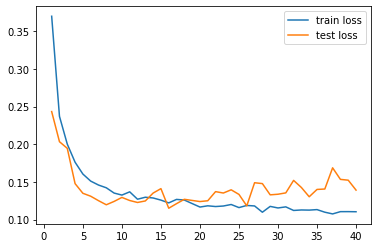

In [151]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

my_ds = DataProccesing()
train_set, test_set=my_ds.DATA_pre_pros(filename_pos,filename_neg)
train_dataloader=data.DataLoader(dataset=train_set, batch_size=64,shuffle=True)
test_dataloader= data.DataLoader(dataset=test_set, batch_size=64,shuffle=True )
print(np.sum(train_set[:, -1]))

LEARNNING_RATE=0.0004
BOOTSTRAP_SIZE=15000
NUMBER_OF_BATCHS=150

model = NetWork(INPUT_DIM, 2)
print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = optim.Adam(model.parameters(),lr=LEARNNING_RATE)

weights = [train_set.shape[0]/(2*np.sum(train_set[:, -1])), np.sum(train_set[:, -1])/(2*(train_set.shape[0]-np.sum(train_set[:, -1])))] #as class distribution

weights.reverse()
print(weights)
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)




EPOCHS = 40

best_valid_loss = float('inf')
train_per_ep=[]
test_per_ep=[]
test_acc = 0
for epoch in range(EPOCHS):


    train_x,train_y=my_ds.shuffle_data(train_set)
    train_iterator_x = torch.from_numpy(train_x.astype('float32')).split(64)
    train_iterator_y = torch.from_numpy(train_y.astype('int64')).split(64)

    test_x,test_y=my_ds.shuffle_data(test_set)
    test_iterator_x = torch.from_numpy(test_x.astype('float32')).split(64)
    test_iterator_y = torch.from_numpy(test_y.astype('int64')).split(64)

    train_loss, train_acc = train(model, train_iterator_x, train_iterator_y, optimizer, criterion, device)

    test_loss, test_acc = evaluate(model, test_iterator_x, test_iterator_y,criterion, device)
    train_per_ep.append(train_loss)
    test_per_ep.append(test_loss)
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

train_per_ep=np.array(train_per_ep)
test_per_ep=np.array(test_per_ep)
epocs=np.arange(1,EPOCHS+1)
print(np.mean(np.abs(np.array(train_per_ep) - np.array(test_per_ep))))
plt.figure()
plt.plot(epocs,train_per_ep)
plt.plot(epocs,test_per_ep)
plt.legend(['train loss','test loss'])
plt.show()

In [185]:

seq=my_ds.spike_seq('/content/ex1_DL/resorces/spike_acid.txt')
print(seq)

seq = torch.from_numpy(seq.astype('float32'))
seq = seq.to(device)
y_pred, _ = model(seq)
z = y_pred
my_softmax = nn.Softmax(dim=1)
z = my_softmax(z)
print(len(torch.where(z[:,1]>0.991)[0]))


MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR